In [7]:
#1.Data Preprocessing
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/dataset.csv')

# Convert date and time columns to datetime objects with the correct format
df['LastUpdated'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')

# Drop the original date and time columns
df = df.drop(columns=['LastUpdatedDate', 'LastUpdatedTime'])

# Display the first few rows of the dataframe
print(df.head())

   ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy VehicleType  \
0   0      BHMBCCMKT01       577  26.144536  91.736172         61         car   
1   1      BHMBCCMKT01       577  26.144536  91.736172         64         car   
2   2      BHMBCCMKT01       577  26.144536  91.736172         80         car   
3   3      BHMBCCMKT01       577  26.144536  91.736172        107         car   
4   4      BHMBCCMKT01       577  26.144536  91.736172        150        bike   

  TrafficConditionNearby  QueueLength  IsSpecialDay         LastUpdated  
0                    low            1             0 2016-10-04 07:59:00  
1                    low            1             0 2016-10-04 08:25:00  
2                    low            2             0 2016-10-04 08:59:00  
3                    low            2             0 2016-10-04 09:32:00  
4                    low            2             0 2016-10-04 09:59:00  


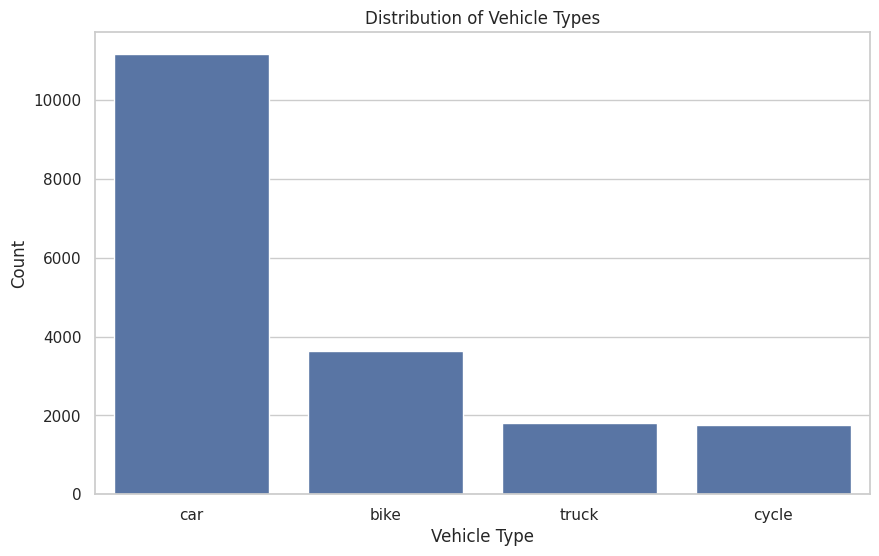

<Figure size 1500x700 with 0 Axes>

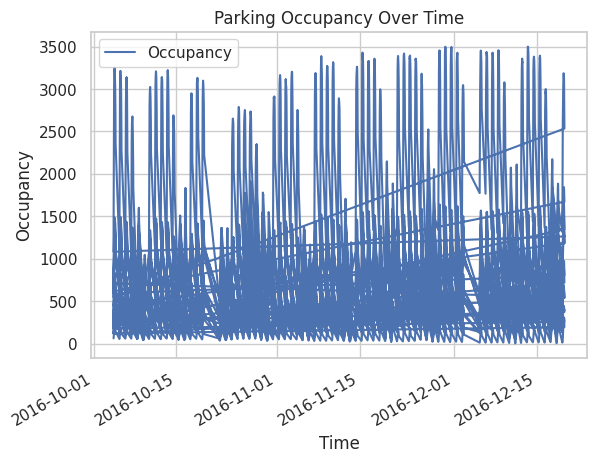

In [8]:
#2. Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Plot the distribution of vehicle types
plt.figure(figsize=(10, 6))
sns.countplot(x='VehicleType', data=df)
plt.title('Distribution of Vehicle Types')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.show()

# Plot the occupancy over time
plt.figure(figsize=(15, 7))
df.plot(x='LastUpdated', y='Occupancy', style='-')
plt.title('Parking Occupancy Over Time')
plt.xlabel('Time')
plt.ylabel('Occupancy')
plt.legend()
plt.show()

In [9]:
#3.Baseline Linear Model
import pandas as pd

# Load data
df = pd.read_csv('/content/dataset.csv')

# Parameters
alpha = 2
base_price = 10

# Compute Baseline Price
df['OccupancyRate'] = df['Occupancy'] / df['Capacity']
df['BaselinePrice'] = base_price + alpha * df['OccupancyRate']


In [12]:
# Example mapping for vehicle type weights (adjust as needed)
vehicle_type_map = {
    'car': 1.0,
    'bike': 0.7,
    'truck': 1.5
}

df['VehicleTypeWeight'] = df['VehicleType'].map(vehicle_type_map).fillna(1.0)  # Default to 1.0 if missing

# If unsure about the categories, check with:
print(df['VehicleType'].unique())


['car' 'bike' 'truck' 'cycle']


In [13]:
vehicle_type_map = {
    'car': 1.0,
    'bike': 0.7,
    'truck': 1.5,
    'cycle': 0.6   # you can adjust this weight if you want
}

df['VehicleTypeWeight'] = df['VehicleType'].map(vehicle_type_map).fillna(1.0)  # Default weight = 1.0


In [24]:
import pandas as pd

# Assume df already loaded and date/time parsed as you did before
# Ensure the columns 'Occupancy', 'Capacity', 'QueueLength', etc. are numeric
df['Occupancy'] = pd.to_numeric(df['Occupancy'], errors='coerce')
df['Capacity'] = pd.to_numeric(df['Capacity'], errors='coerce')
df['QueueLength'] = pd.to_numeric(df['QueueLength'], errors='coerce')

# Occupancy Rate
df['OccupancyRate'] = df['Occupancy'] / df['Capacity']

# Map Traffic Condition
traffic_map = {'low': 0, 'average': 0.5, 'high': 1}
df['TrafficLevel_Norm'] = df['TrafficConditionNearby'].map(traffic_map).fillna(0.5)

# Map Vehicle Type Weights
vehicle_type_map = {'car': 1.0, 'bike': 0.7, 'truck': 1.5, 'cycle': 0.6}
df['VehicleTypeWeight'] = df['VehicleType'].map(vehicle_type_map).fillna(1.0)
# Show the new columns
print(df[['OccupancyRate', 'TrafficLevel_Norm', 'VehicleType', 'VehicleTypeWeight']].head())



   OccupancyRate  TrafficLevel_Norm VehicleType  VehicleTypeWeight
0       0.105719                0.0         car                1.0
1       0.110919                0.0         car                1.0
2       0.138648                0.0         car                1.0
3       0.185442                0.0         car                1.0
4       0.259965                0.0        bike                0.7


In [15]:
#2. Baseline Model
# Linear price increase from $10 to $20 as occupancy goes from 0% to 100%
df['BaselinePrice'] = 10 + (df['OccupancyRate'] * 10)


In [25]:
#4. Demand-Based Model
from sklearn.preprocessing import MinMaxScaler

alpha, beta, gamma, delta, epsilon = 2, 0.5, 1, 1, 0.2
lambda_ = 0.5
base_price = 10

# Demand formula
df['RawDemand'] = (alpha * df['OccupancyRate'] +
                   beta * df['QueueLength'] -
                   gamma * df['TrafficLevel_Norm'] +
                   delta * df['IsSpecialDay'] +
                   epsilon * df['VehicleTypeWeight'])

scaler = MinMaxScaler()
df['NormalizedDemand'] = scaler.fit_transform(df[['RawDemand']])

df['DemandPrice'] = base_price * (1 + lambda_ * df['NormalizedDemand'])
df['DemandPrice'] = df['DemandPrice'].clip(lower=0.5*base_price, upper=2*base_price)
# Display the new columns relevant to demand-based pricing
print(df[['OccupancyRate', 'QueueLength', 'TrafficLevel_Norm', 'IsSpecialDay',
          'VehicleTypeWeight', 'RawDemand', 'NormalizedDemand', 'DemandPrice']].head(10))



   OccupancyRate  QueueLength  TrafficLevel_Norm  IsSpecialDay  \
0       0.105719            1                0.0             0   
1       0.110919            1                0.0             0   
2       0.138648            2                0.0             0   
3       0.185442            2                0.0             0   
4       0.259965            2                0.0             0   
5       0.306759            3                0.0             0   
6       0.379549            6                1.0             0   
7       0.428076            5                0.5             0   
8       0.448873            5                0.5             0   
9       0.461005            8                1.0             0   

   VehicleTypeWeight  RawDemand  NormalizedDemand  DemandPrice  
0                1.0   0.911438          0.078852    10.394258  
1                1.0   0.921837          0.079970    10.399849  
2                1.0   1.477296          0.139697    10.698487  
3            

In [26]:
#5. Competitive Model
from scipy.spatial.distance import cdist

# For demo: Assign each lot's comp price as the BaselinePrice of its nearest competitor (except itself)
coords = df[['Latitude', 'Longitude']].values
dist_matrix = cdist(coords, coords)
np.fill_diagonal(dist_matrix, np.inf)  # don't consider itself as a competitor

nearest_idx = dist_matrix.argmin(axis=1)
df['CompPrice'] = df.iloc[nearest_idx]['BaselinePrice'].values
print(df[['ID', 'Latitude', 'Longitude', 'BaselinePrice', 'CompPrice']].head(10))



   ID   Latitude  Longitude  BaselinePrice  CompPrice
0   0  26.144536  91.736172      11.057192  11.109185
1   1  26.144536  91.736172      11.109185  11.057192
2   2  26.144536  91.736172      11.386482  11.057192
3   3  26.144536  91.736172      11.854419  11.057192
4   4  26.144536  91.736172      12.599653  11.057192
5   5  26.144536  91.736172      13.067591  11.057192
6   6  26.144536  91.736172      13.795494  11.057192
7   7  26.144536  91.736172      14.280763  11.057192
8   8  26.144536  91.736172      14.488735  11.057192
9   9  26.144536  91.736172      14.610052  11.057192


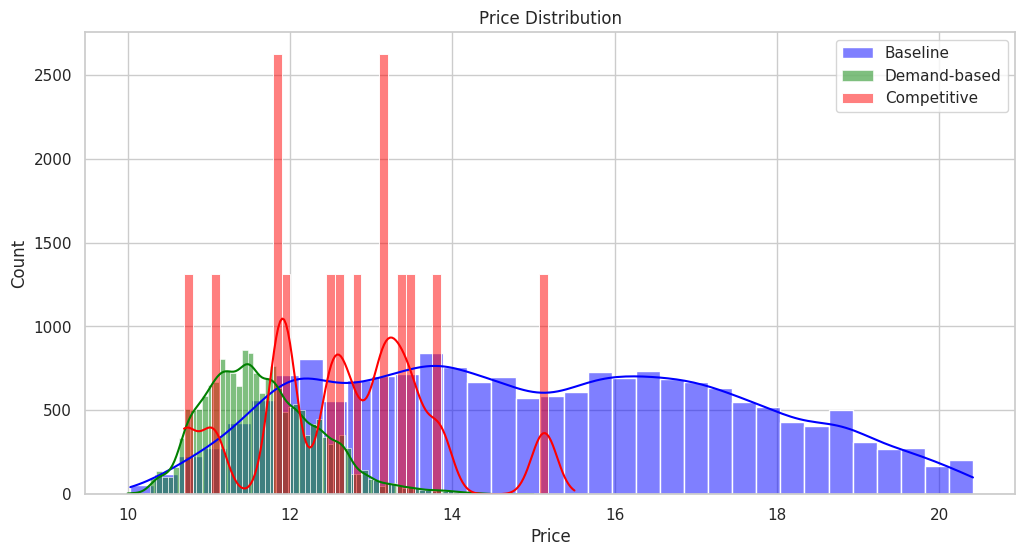

In [18]:
#5. Visualization (Matplotlib & Seaborn)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.histplot(df['BaselinePrice'], color='blue', label='Baseline', kde=True)
sns.histplot(df['DemandPrice'], color='green', label='Demand-based', kde=True)
sns.histplot(df['CompPrice'], color='red', label='Competitive', kde=True)
plt.legend()
plt.title('Price Distribution')
plt.xlabel('Price')
plt.show()


In [22]:
df['LastUpdated'] = pd.to_datetime(
    df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
    format='%d-%m-%Y %H:%M:%S'
)


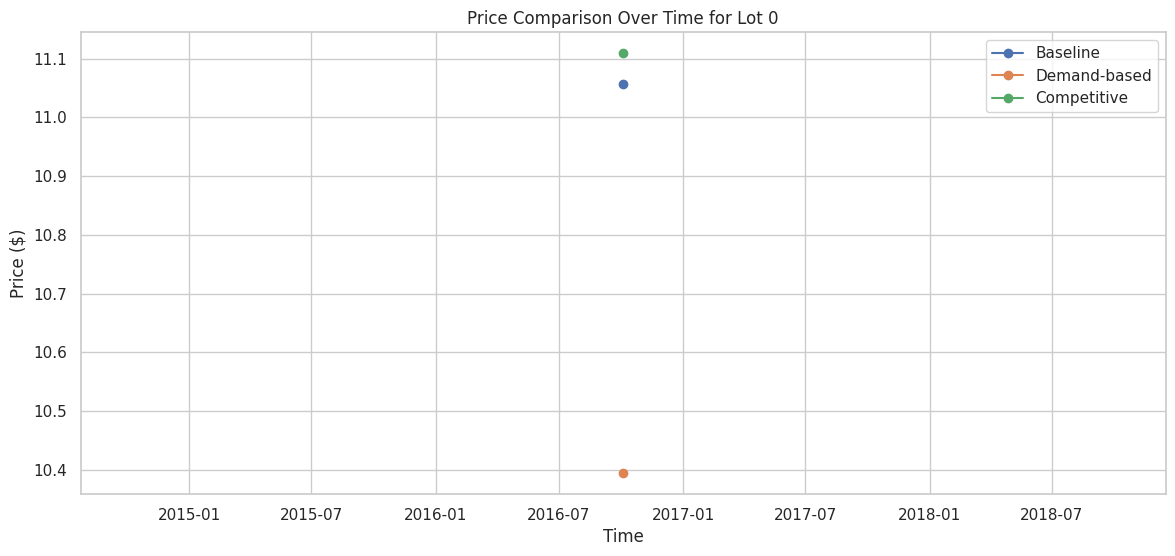

In [23]:
lot_id = df['ID'].iloc[0]  # Or pick any specific lot ID you want
lot_df = df[df['ID'] == lot_id].sort_values('LastUpdated')

plt.figure(figsize=(14,6))
plt.plot(lot_df['LastUpdated'], lot_df['BaselinePrice'], marker='o', label='Baseline')
plt.plot(lot_df['LastUpdated'], lot_df['DemandPrice'], marker='o', label='Demand-based')
plt.plot(lot_df['LastUpdated'], lot_df['CompPrice'], marker='o', label='Competitive')
plt.legend()
plt.title(f'Price Comparison Over Time for Lot {lot_id}')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.show()
